<h1>Authorship attribution with Markov Chain</h1>

Given a piece of work, how do we identify its author? This piece of work aimed to give a brief idea on authorship attribution using Markov Chain.

Authorship attribution (AA) is the task of identifying the author of a given text. It should not be confused with Authorship Profiling that concern with the author’s information such as age, gender or ethnicity.

## Data Set
Project Gutenberg (PG) is an online digital library that aims to encourage the creation and distribution of eBooks (Project Gutenberg 2018). It is recognised as the oldest digital library in the world. 

Today, Project Gutenberg has more than 60,000 free eBooks in its collection. Most of the published eBooks in the collection had received copyright clearance, making it an ideal testing ground for research.

Credit to Lahiri and Shibamouli for contributing the pre-cleaned data set.
https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html

In [1]:
#Figure below shows the training and testing data preparation:
#<img src="files/data prep.png">

import numpy as np
import pandas as pd
import math

In [2]:
## Extract training document path from csv file
 
book_author_list = pd.read_csv("C:/Users/Teng Li Yuan/Desktop/Gutenberg_training.csv")
book_author_list_df = pd.DataFrame(book_author_list)
book_path = book_author_list["Path"]

test_chapter_list = pd.read_csv("C:/Users/Teng Li Yuan/Desktop/Gutenberg_test.csv")
test_chapter_list_df = pd.DataFrame(test_chapter_list)
test_chapter_list_path = test_chapter_list["Path"]

LDA_train_chapter_list = pd.read_csv("C:/Users/Teng Li Yuan/Desktop/LDA_Training.csv")
LDA_train_chapter_list_df = pd.DataFrame(LDA_train_chapter_list)
LDA_train_chapter_list_path = LDA_train_chapter_list_df["Path"]

Our testing data contain 200 books where 20 authors each contribute 10 books.
We simplify the authors' name and make it into a list, __Simp_True_label__ 

In [3]:
u = ['Alfred R W',
 'Baronness Orczy',
 'Benjamin Disraeli',
 'Benjamin Franklin',
 'Bertrand Russell',
 'Charles Darwin',
 'Charles Dickens',
 'Charlotte Bronte',
 'Charlotte M Y',
 'D H Lawrence',
 'Daniel Defoe',
 'Edward P O',
 'George Eliot',
 'Hamlin Garland',
 'Harold B',
 'Herbert G W',
 'Howard Pyle',
 'Jack London',
 'James F C',
 'Jane Austen']

Simp_True_Label_df = []

for i in u:
    for j in range(10):
        Simp_True_Label_df.append(i)

## Exploratory Data Analysis
### Characters Distribution
Next, we need to limit the number of characters use in this project as this determines how many states use in the Markov Chain.

A prior character distribution study of the data set indicates:
1. 77% alphabets (99.9% English alphabets, <0.1% non-English alphabets)
2. 22% symbols  (99% Symbols are " ", "-", "'", '"', ".", "," , "\n")
3. <1% numeric  

### Data Quality Issues
1. Presence of minority characters (Non-English alphabets, rare symbols). This is viewed as zero-likelihood event when it appears in testing data but not in training data.
2. Multiple blank spaces, newline chracters '\n'
3. Non-author content in the book, for example transcriber notes, license information etc

### How to solve?
1. Grouping the minority characters into single 'other' category. (*note: we use "ö" notation for this group)
2. Replace / remove. For instance, replace '\n' with ' '.
3. Lowercase all the characters.
4. Manual remove non-author content.

In [4]:
character_allow = [ " ", "-", "'", '"', ".", ","]   ##Allowed Character "\n",
alphabet_allow = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p",
                       "q", "r", "s", "t", "u", "v", "w", "x", "y","z", "ö"]
def character_process(char):
    char = char.lower()
    if char.isnumeric():
        return " "
    if char.isalpha():
        if (char in alphabet_allow):
            return char
        else:
            return "ö"
    if char in character_allow:
        #if char=='\n':
            #return " "
        return char
    else:
        return " "

### Raw text and clean text

In [5]:
#Test Cleaning character
with open(r"C:\Users\Teng Li Yuan\Desktop\line num.txt",  encoding="utf8", mode='r') as f:
    corpus=f.read()
char_list = ""
corpus=corpus.replace("\n", " ")
for char in corpus: 
    clean_char = character_process(char)
    char_list = char_list+clean_char
str_char = ''.join(char_list)
clean_char=' '.join(str_char.split()) 

In [6]:
## Note the line numbering, brackets and multiple indentatation, new space character and blank space characters were cleaned
corpus

'  Never did pulse so quickly throb,   And never heart so loudly panted; [56]   He looks, he cannot choose but look;   Like some one reading in a book--[57]   A book that is enchanted.                                520    Ah, well-a-day for Peter Bell!   He will be turned to iron soon,   Meet Statue for the court of Fear!   His hat is up--and every hair   Bristles, and whitens in the moon!                       525'

In [7]:
clean_char

'never did pulse so quickly throb, and never heart so loudly panted he looks, he cannot choose but look like some one reading in a book-- a book that is enchanted. ah, well-a-day for peter bell he will be turned to iron soon, meet statue for the court of fear his hat is up--and every hair bristles, and whitens in the moon'

### Create Transition Matrix

In [8]:
# with open(test_chapter_list_path[0],  encoding="utf8", mode='r') as f:
#     corpus=f.read()
# char_list = ""
# corpus=corpus.replace("\n", " ")
# for char in corpus: 
#     clean_char = character_process(char)
#     char_list = char_list+clean_char
# str_char = ''.join(char_list)
# clean_char=' '.join(str_char.split()) 
# test_chapter_list_path[0]

In [9]:
#Create transition matrix base on the path from csv file
class training_book:
    def __init__(self, book_path):
        self.book_path = book_path
    
    def create_transition_matrix(self):
        with open(self.book_path,  encoding="utf8", mode='r') as f:
            corpus=f.read()
        corpus=corpus.replace("\n", " ")
        char_list = []
        for char in corpus:
            clean_char = character_process(char)
            char_list.append(clean_char)
        
        str_char = ''.join(char_list)
        clean_char=' '.join(str_char.split()) 
        
        #Sort the distinct letter
        distinct_words = character_allow + alphabet_allow  ## set of 26 character + punctuations
        distinct_words.sort()

        #create word2id and id2word dictionary
        word2id_dict = {}
        id2word_dict = {}
        for index, word in enumerate(distinct_words):
            word2id_dict[word] = index
            id2word_dict[index] = word

        #Initialize empty transition matrix
        M = N = len(distinct_words)  ## Limit to 33 characters
        transition_matrix = np.zeros((M, N))

        #Create 1st order Markov Chain (Number of occurance)
        for i in range(len(char_list)-1):
            current_word = char_list[i]
            current_word_id = word2id_dict[current_word]
            next_word = char_list[i+1]
            next_word_id = word2id_dict[next_word]
            transition_matrix[current_word_id][next_word_id] = transition_matrix[current_word_id][next_word_id] + 1

        sum_of_each_row_all  = np.sum(transition_matrix, 1)

        #Turn the no. of occurance to probability
        for i in range (len(distinct_words)):
            single_row_sum = sum_of_each_row_all[i]            
            if (sum_of_each_row_all [i] == 0):
                single_row_sum = 1            
            transition_matrix[ i,: ] =  transition_matrix[ i,: ] / single_row_sum
        return word2id_dict, id2word_dict, transition_matrix # All we need here is the transition matrix, 
                                                             # The word2id & id2word were kept in case 
                                                             # we decided not to limit the number of characters

Create transition matrix of test set __A__

In [10]:
## Obtain the test_chapter_transition_matrix and store in test_chapter_trans_list
test_chapter_list = []
test_chapter_word2id_dict_list = []
test_chapter_id2word_dict_list= []
test_chapter_trans_list = []

for i in range (len(test_chapter_list_path)):
    test_chapter_list.append(training_book(test_chapter_list_path[i]))
    a, b, c = test_chapter_list[i].create_transition_matrix()
    test_chapter_word2id_dict_list.append(a)
    test_chapter_id2word_dict_list.append(b)
    test_chapter_trans_list.append(c)

Create transition matrix of test set __B__

In [11]:
LDA_book_list = []
LDA_trans_list = []

for i in range (len(LDA_train_chapter_list_path)):
    LDA_book_list.append(training_book(LDA_train_chapter_list_path[i]))
    a, b, c = LDA_book_list[i].create_transition_matrix()
    LDA_trans_list.append(c)

In [12]:
book_list =   []
word2id_dict_list = []
id2word_dict_list= []
trans_list = []

for i in range (len(book_path)):
    book_list.append(training_book(book_path[i]))
    a, b, c = book_list[i].create_transition_matrix()
    word2id_dict_list.append(a)
    id2word_dict_list.append(b)
    trans_list.append(c)   

## Similarity Measurement

The main idea behind the AA is that by extracting some measurable textual features (Stylometry features) ,we can discriminate the true author of the given text that shares with similar features. 

In this work, we focus on character-level features where words can be viewed as a sequence of characters. Character-level features has the advantages of language-independent (at least for most of the languages) and robust to spelling errors (Like typo, as compare to lexical feature). 

The probability of next characters are governed by individual's English vocabulary ( To describe good food, one may use delicious / tasty / amazing food etc ), writing style (American -ize, British -ise )and spelling error (Compile, Compille).

Here, we demonstrate similarity measurement using
1. Log-likelihood (https://en.wikipedia.org/wiki/Likelihood_function)
2. KL Divergence (https://machinelearningmastery.com/divergence-between-probability-distributions/)
3. JS Divergence (https://machinelearningmastery.com/divergence-between-probability-distributions/)
4. Linear Discriminant Analysis  (https://multivariatestatsjl.readthedocs.io/en/latest/mclda.html)

In [13]:
## Calculate Log-likelihood
def Sum_log_likelihood(transition_matrix, test_path, word2id_dict):
    test_chapter=''
    clean_test_chapter = []
    with open(test_path,  encoding="utf8", mode='r') as f:
        test_chapter=f.read()
    test_chapter=test_chapter.replace("\n", " ")  

    for char in test_chapter:
        clean_charr = character_process(char)
        clean_test_chapter.append(clean_charr)

    str_char = ''.join(clean_test_chapter)
    clean_test_chapter=' '.join(str_char.split()) 
    
    len_clean = len(clean_test_chapter) 
    log_likelihood = np.zeros(0)
    for i in range(0, len(clean_test_chapter)-1):
        current_word = clean_test_chapter[i]
        next_word = clean_test_chapter[i+1]
        Step_probab = transition_matrix[word2id_dict[current_word] , word2id_dict[next_word]]    
        log_likelihood = np.append(log_likelihood, Step_probab) 

    log_likelihood = np.log(log_likelihood)
    likelihood_neglect_special_case = 0
    inf_count = 0

    for i in range(len(log_likelihood)):
        if (log_likelihood[i]!= float("-inf")):
            likelihood_neglect_special_case = likelihood_neglect_special_case+log_likelihood[i] 
        else:
            inf_count = inf_count+1 

    log_likelihood_acc = np.where(log_likelihood == float("-inf"), 0,  log_likelihood)
    log_likelihood_acc = np.cumsum(log_likelihood_acc)
    return likelihood_neglect_special_case/(len_clean-inf_count), log_likelihood_acc

In [14]:
def kl_divergence(test_p, author_q, threshold = 0.2):
    result = []
    for i in range(len(test_p)):
        row_KL = []
        for j in range(len(test_p[i])):
            if (test_p[i][j] == 0):
                KL_div = 0
            elif(author_q[i][j] == 0):
                KL_div = threshold   ## Special case where q is 0
            else:
                KL_div = test_p[i][j] * math.log(test_p[i][j]/author_q[i][j])                                    
            row_KL.append(KL_div)
        result.append(sum(row_KL))          
    return result

def js_divergence(p, q, thres = 0.2):
    m = np.multiply(0.5, np.add(p, q))
    y = np.add(np.multiply(0.5, kl_divergence(p, m, thres)) ,np.multiply(kl_divergence(q, m, thres), 0.5))
    return y

### Prediction

In [15]:
##Log-likelihood Prediction

author_prediction = []
likelihood_all_book = []
log_investigation_list = np.zeros((len(test_chapter_list_path),len(book_path)), dtype=object) 

for j in range (len(test_chapter_list_path)):
    likelihood_individual_book = []
    
    for i in range (len(book_path)):
        ##new log-invest
        a, b =Sum_log_likelihood(trans_list[i], test_chapter_list_path[j], word2id_dict_list[i])        
        log_investigation_list[j][i] = b        
        likelihood_individual_book.append(a)
        print("predicting test*********** " + str(j) + " with book "+ str(i))    

    likelihood_all_book.append(likelihood_individual_book)
    prediction = book_path[likelihood_individual_book.index(max(likelihood_individual_book))]
    author_prediction.append(prediction)

predicting test*********** 0 with book 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


predicting test*********** 0 with book 1
predicting test*********** 0 with book 2
predicting test*********** 0 with book 3
predicting test*********** 0 with book 4
predicting test*********** 0 with book 5
predicting test*********** 0 with book 6
predicting test*********** 0 with book 7
predicting test*********** 0 with book 8
predicting test*********** 0 with book 9
predicting test*********** 0 with book 10
predicting test*********** 0 with book 11
predicting test*********** 0 with book 12
predicting test*********** 0 with book 13
predicting test*********** 0 with book 14
predicting test*********** 0 with book 15
predicting test*********** 0 with book 16
predicting test*********** 0 with book 17
predicting test*********** 0 with book 18
predicting test*********** 0 with book 19
predicting test*********** 1 with book 0
predicting test*********** 1 with book 1
predicting test*********** 1 with book 2
predicting test*********** 1 with book 3
predicting test*********** 1 with book 4
predic

In [16]:
start = 0

#log_save_result_path=r"C:/Users/Teng Li Yuan/Desktop/Dissertation result plot/1st order log investigation_wrong_"+str(start)+".png"

likelihood_df = pd.DataFrame(np.array(likelihood_all_book[start:start+10]))
likelihood_df.columns = u

w=likelihood_df.mean().keys()
n=pd.Series.to_numpy(likelihood_df.mean())

import matplotlib.pyplot as plt
import numpy as np
fig_dims = (10, 2)
fig, ax = plt.subplots(figsize=fig_dims)

df = pd.DataFrame({'x' : w , 'y' : n})
#df["y"]=df["y"]
df = df.sort_values('y', ascending = True)
df_top5 = df[15:20]
plt.barh(df_top5["x"], df_top5["y"] )
#plt.yticks(range(len(w)),w)

for index, value in enumerate(df_top5["y"]):
    plt.text(value, index, str(round(value, 4)), fontsize=8)

    
#plt.savefig(log_save_result_path, dpi = 200)
plt.show()


<Figure size 1000x200 with 1 Axes>

In [17]:
## KL Divergence Prediction
thres = 0.2
KL_prediction_list = []
#1 chapter to 8 book
for j in range (len(test_chapter_list_path)):
    KL_divergence_chap_trans_and_book_trans_list = []
    for i in range (len(book_path)):
        single_test_to_1_book = kl_divergence( test_chapter_trans_list[j], trans_list[i], thres)
        sum_of_1_test_to_1_book = np.sum(single_test_to_1_book) #Sum of all KL divergence
        KL_divergence_chap_trans_and_book_trans_list.append(sum_of_1_test_to_1_book)
    book_prediction = book_path[KL_divergence_chap_trans_and_book_trans_list.index(min(KL_divergence_chap_trans_and_book_trans_list))]
    KL_prediction_list.append(book_prediction)

In [18]:
## JS Divergence Prediction
js_thres = 0.2

js_prediction_list = []
for j in range (len(test_chapter_list_path)):
    js_divergence_chap_trans_and_book_trans_list = []
    for i in range (len(book_path)):
        print(test_chapter_list_path[j] +" to "+ book_path[i] )
        single_test_to_1_book = js_divergence(test_chapter_trans_list[j], trans_list[i], js_thres)
        sum_of_1_test_to_1_book = np.sum(single_test_to_1_book) #Sum of all JS divergence
        #print(sum_of_1_test_to_1_book)
        js_divergence_chap_trans_and_book_trans_list.append(sum_of_1_test_to_1_book)
    js_book_prediction = book_path[js_divergence_chap_trans_and_book_trans_list.index(min(js_divergence_chap_trans_and_book_trans_list))]
    js_prediction_list.append(js_book_prediction)

C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Test_split/Alfred Russel Wallace$0.txt to C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Training/Alfred Russel Wallace.txt
C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Test_split/Alfred Russel Wallace$0.txt to C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Training/Baronness Orczy.txt
C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Test_split/Alfred Russel Wallace$0.txt to C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Training/Benjamin Disraeli.txt
C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Test_split/Alfred Russel Wallace$0.txt to C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Training/Benjamin Franklin.txt
C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Test_split/Alfred Russel Wallace$0.txt to C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Training/Bertrand Russell.txt
C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Test_split/Alfred Russel Wallace$0.txt to C:/Users/Teng Li Yuan/Desktop/Clean_Gutenberg/Training/Charles Darwin.txt
C:/Users/Ten

In [19]:
## Split the training path into the auhtor's name

LDA_true_train = []

for i in range (len(LDA_train_chapter_list_path)):
    LDA_true_train.append(LDA_train_chapter_list_path[i].split("/")[-1].split(".txt")[0].split("$")[0])

In [20]:
def accuracy(author_prediction, test_chapter_list_path):
    correct_prediction = 0
    wrong_prediction = 0
    for i in range (len(test_chapter_list_path)):
        if (author_prediction[i].split("/")[-1]).split(".")[0] == (test_chapter_list_path[i].split("/")[-1]).split("___")[0].split("$")[0]:
            correct_prediction=correct_prediction+1
        else:
            wrong_prediction=wrong_prediction+1
    accuracy = correct_prediction / (correct_prediction + wrong_prediction)
    return accuracy

In [21]:
log_pred = []
KL_pred = []
JS_pred = []
True_aut = []
ensemb_pred = []
dominant_model = [ ]

for i in range (len(test_chapter_list_path)):
    True_aut.append(test_chapter_list_path[i].split("/")[-1].split("___")[0].split("$")[0])
    log_pred.append(author_prediction[i].split("/")[-1].split(".")[0])
    KL_pred.append(KL_prediction_list[i].split("/")[-1].split(".")[0])
    JS_pred.append(js_prediction_list[i].split("/")[-1].split(".")[0])

In [22]:
# LDA prediction preparation
a= LDA_true_train
a= np.array(a) 

c = LDA_trans_list
c =np.array(c)
d = []
for i in range(len(c)):
    d.append(c[i].flatten() )
d =np.array(d)

f = test_chapter_trans_list
f =np.array(f)
test_TM = []
for i in range(len(f)):
    test_TM.append(f[i].flatten() )
test_TM =np.array(test_TM)

print(a.shape)
print(c.shape)
print(d.shape)
print(test_TM.shape)

(196,)
(196, 33, 33)
(196, 1089)
(200, 1089)


In [23]:
##LDA Prediction

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X = d
y = a
clf = LDA()
clf.fit(X, y)
LDA(n_components=None, priors=None)
LDA_pred = clf.predict(test_TM)  ## Correct

book_aut = []
for i in range(len(book_path)):
    book_aut.append(book_path[i].split("/")[-1].split(".txt")[0])

correct = 0
wrong = 0

for i in range(len(True_aut)):
    if LDA_pred[i] == True_aut[i]:
        correct =  correct+1
    else:
        wrong = wrong + 1
        
LDA_accuracy = correct / (correct + wrong)

print(LDA_accuracy)

0.67


### Evaluation
The ensemble model with majority voting uses the four models (Log-likelihood, KL divergence, JS divergence, LDA) and output the simple majority as prediction 

In the case of equal number of votes, use the single highest accuracy model (Thus we need to evaluate the four models performance first).

In [24]:
All_prediction = [log_pred,KL_pred,JS_pred, LDA_pred]
accuracy_list = [accuracy(author_prediction, test_chapter_list_path), accuracy(KL_prediction_list, test_chapter_list_path), accuracy(js_prediction_list, test_chapter_list_path), LDA_accuracy]
ensemb_pred = []

max_accuracy = max(accuracy_list) 
for j in range(4):
    if max_accuracy == accuracy_list[j]:
        dominant_model=All_prediction[j]
        break
        
for i in range (len(test_chapter_list_path)):
    temp_list = [log_pred[i], KL_pred[i], JS_pred[i], LDA_pred[i]]
    
    domi = dominant_model[i]
    print(i, "**Dominant is", domi)
    majority = max(set(temp_list), key = temp_list.count)
    print(i, "**Majority is", majority)    
    num_list=[]
    for j in set(temp_list):
        num_list.append(temp_list.count(j))
    print("The num list is " , num_list)
    if (4 in num_list) or (3 in num_list): # 3 or 4 votes, choose majority
        en_pre=  majority#Use majority
        print("3 or 4 in it, use majority")
    else: #(no 3 or 4)
        if (2 in num_list):  ## There is a vote of 2 no 3 or 4
            if  (1 in num_list): # There is 2, 1,1 
                en_pre=majority # Use majority, else: do nothing (Use back Dominant)
                print("2,1, 1, use majority")
            else:
                en_pre = domi
                print("2, 2 use dominant")
        else:
            print("both equally 1, use dominant")
            en_pre = domi
            
    print("en_pre is " ,en_pre)
    
    ensemb_pred.append(en_pre) #Use dominant prediction
    
correct = 0
wrong = 0

#get ensemble accuracy
for i in range(len(test_chapter_list_path)):
    if ensemb_pred[i] == True_aut[i]:
        correct =  correct+1
    else:
        wrong = wrong + 1
        
en_accuracy = correct / (correct + wrong)
    

0 **Dominant is Alfred Russel Wallace
0 **Majority is Alfred Russel Wallace
The num list is  [4]
3 or 4 in it, use majority
en_pre is  Alfred Russel Wallace
1 **Dominant is Bertrand Russell
1 **Majority is Alfred Russel Wallace
The num list is  [1, 3]
3 or 4 in it, use majority
en_pre is  Alfred Russel Wallace
2 **Dominant is Alfred Russel Wallace
2 **Majority is Alfred Russel Wallace
The num list is  [4]
3 or 4 in it, use majority
en_pre is  Alfred Russel Wallace
3 **Dominant is Alfred Russel Wallace
3 **Majority is Alfred Russel Wallace
The num list is  [4]
3 or 4 in it, use majority
en_pre is  Alfred Russel Wallace
4 **Dominant is Alfred Russel Wallace
4 **Majority is Charles Darwin
The num list is  [2, 2]
2, 2 use dominant
en_pre is  Alfred Russel Wallace
5 **Dominant is Alfred Russel Wallace
5 **Majority is Alfred Russel Wallace
The num list is  [4]
3 or 4 in it, use majority
en_pre is  Alfred Russel Wallace
6 **Dominant is Alfred Russel Wallace
6 **Majority is Alfred Russel Walla

In [25]:
from termcolor import colored

for i in range (len(test_chapter_list_path)):
    L_color = "green"
    K_color = "green"
    J_color = "green"
    LDA_color = "green"    
    E_color = "green"
        
    if True_aut[i]  != log_pred[i]: L_color="red"
    if True_aut[i]  != KL_pred[i]: K_color="red"
    if True_aut[i]  != JS_pred[i]: J_color="red"
    if True_aut[i]  != LDA_pred[i]: LDA_color="red"        
    if True_aut[i]  != ensemb_pred[i]: E_color="red"    
    

    text = str(i) + colored('L', L_color, attrs=['reverse', 'blink']) + " " + colored('K', K_color, attrs=['reverse', 'blink']) + " " +colored('J', J_color, attrs=['reverse', 'blink'])+ " " +colored('D', LDA_color, attrs=['reverse', 'blink'])+" " +colored('E', E_color, attrs=['reverse', 'blink'])
    print(text)
    

0L K J D E
1L K J D E
2L K J D E
3L K J D E
4L K J D E
5L K J D E
6L K J D E
7L K J D E
8L K J D E
9L K J D E
10L K J D E
11L K J D E
12L K J D E
13L K J D E
14L K J D E
15L K J D E
16L K J D E
17L K J D E
18L K J D E
19L K J D E
20L K J D E
21L K J D E
22L K J D E
23L K J D E
24L K J D E
25L K J D E
26L K J D E
27L K J D E
28L K J D E
29L K J D E
30L K J D E
31L K J D E
32L K J D E
33L K J D E
34L K J D E
35L K J D E
36L K J D E
37L K J D E
38L K J D E
39L K J D E
40L K J D E
41L K J D E
42L K J D E
43L K J D E
44L K J D E
45L K J D E
46L K J D E
47L K J D E
48L K J D E
49L K J D E
50L K J D E
51L K J D E
52L K J D E
53L K J D E
54L K J D E
55L K J D E
56L K J D E
57L K J D E
58L K J D E
59L K J D E
60L K J D E
61L K J D E
62L K J D E
63L K J D E
64L K J D E
65L K J D E
66L K J D E
67L K J D E
68L K J D E
69L K J D E
70L K J D E
71L K J D E
72L K J D E
73L K J D E
74L K J D E
75L K J D E
76L K J D E
77L K J D E
78L K J D E
79L K J D E
80L K J D E
81L K J D E
82L K J D E
83L K J D E
84

### Confusion Matrix

In [26]:
#log-likelihood
#KL Divergence accuracy
#JS Divergence accuracy

print("log-likelihood accuracy is" , accuracy(author_prediction, test_chapter_list_path))
print("KL divergence  accuracy is" , accuracy(KL_prediction_list, test_chapter_list_path))
print("JS divergence  accuracy is" , accuracy(js_prediction_list, test_chapter_list_path))
print("LDA accuracy is" , LDA_accuracy)
print("Ensemble model accuracy is" , en_accuracy)

log-likelihood accuracy is 0.67
KL divergence  accuracy is 0.58
JS divergence  accuracy is 0.585
LDA accuracy is 0.67
Ensemble model accuracy is 0.745


In [29]:
aut_orig = list(set(True_aut))
aut_orig.sort()

In [30]:
from sklearn.metrics import classification_report

In [31]:
Simp_True_Label = ['Alfred R W',
 'Baronness Orczy',
 'Benjamin Disraeli',
 'Benjamin Franklin',
 'Bertrand Russell',
 'Charles Darwin',
 'Charles Dickens',
 'Charlotte Bronte',
 'Charlotte M Y',
 'D H Lawrence',
 'Daniel Defoe',
 'Edward P O',
 'George Eliot',
 'Hamlin Garland',
 'Harold B',
 'Herbert G W',
 'Howard Pyle',
 'Jack London',
 'James F C',
 'Jane Austen']

C:\Users\Teng Li Yuan\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

    Alfred Russel Wallace       1.00      0.70      0.82        10
          Baronness Orczy       1.00      0.50      0.67        10
        Benjamin Disraeli       1.00      0.80      0.89        10
        Benjamin Franklin       1.00      1.00      1.00        10
         Bertrand Russell       0.77      1.00      0.87        10
           Charles Darwin       0.91      1.00      0.95        10
          Charles Dickens       0.00      0.00      0.00        10
         Charlotte Bronte       0.83      1.00      0.91        10
     Charlotte Mary Yonge       0.29      0.20      0.24        10
             D H Lawrence       0.00      0.00      0.00        10
             Daniel Defoe       0.77      1.00      0.87        10
Edward Phillips Oppenheim       0.71      1.00      0.83        10
             George Eliot       1.00      0.70      0.82        10
           Hamlin Garland       0.06      0.10      0.07     

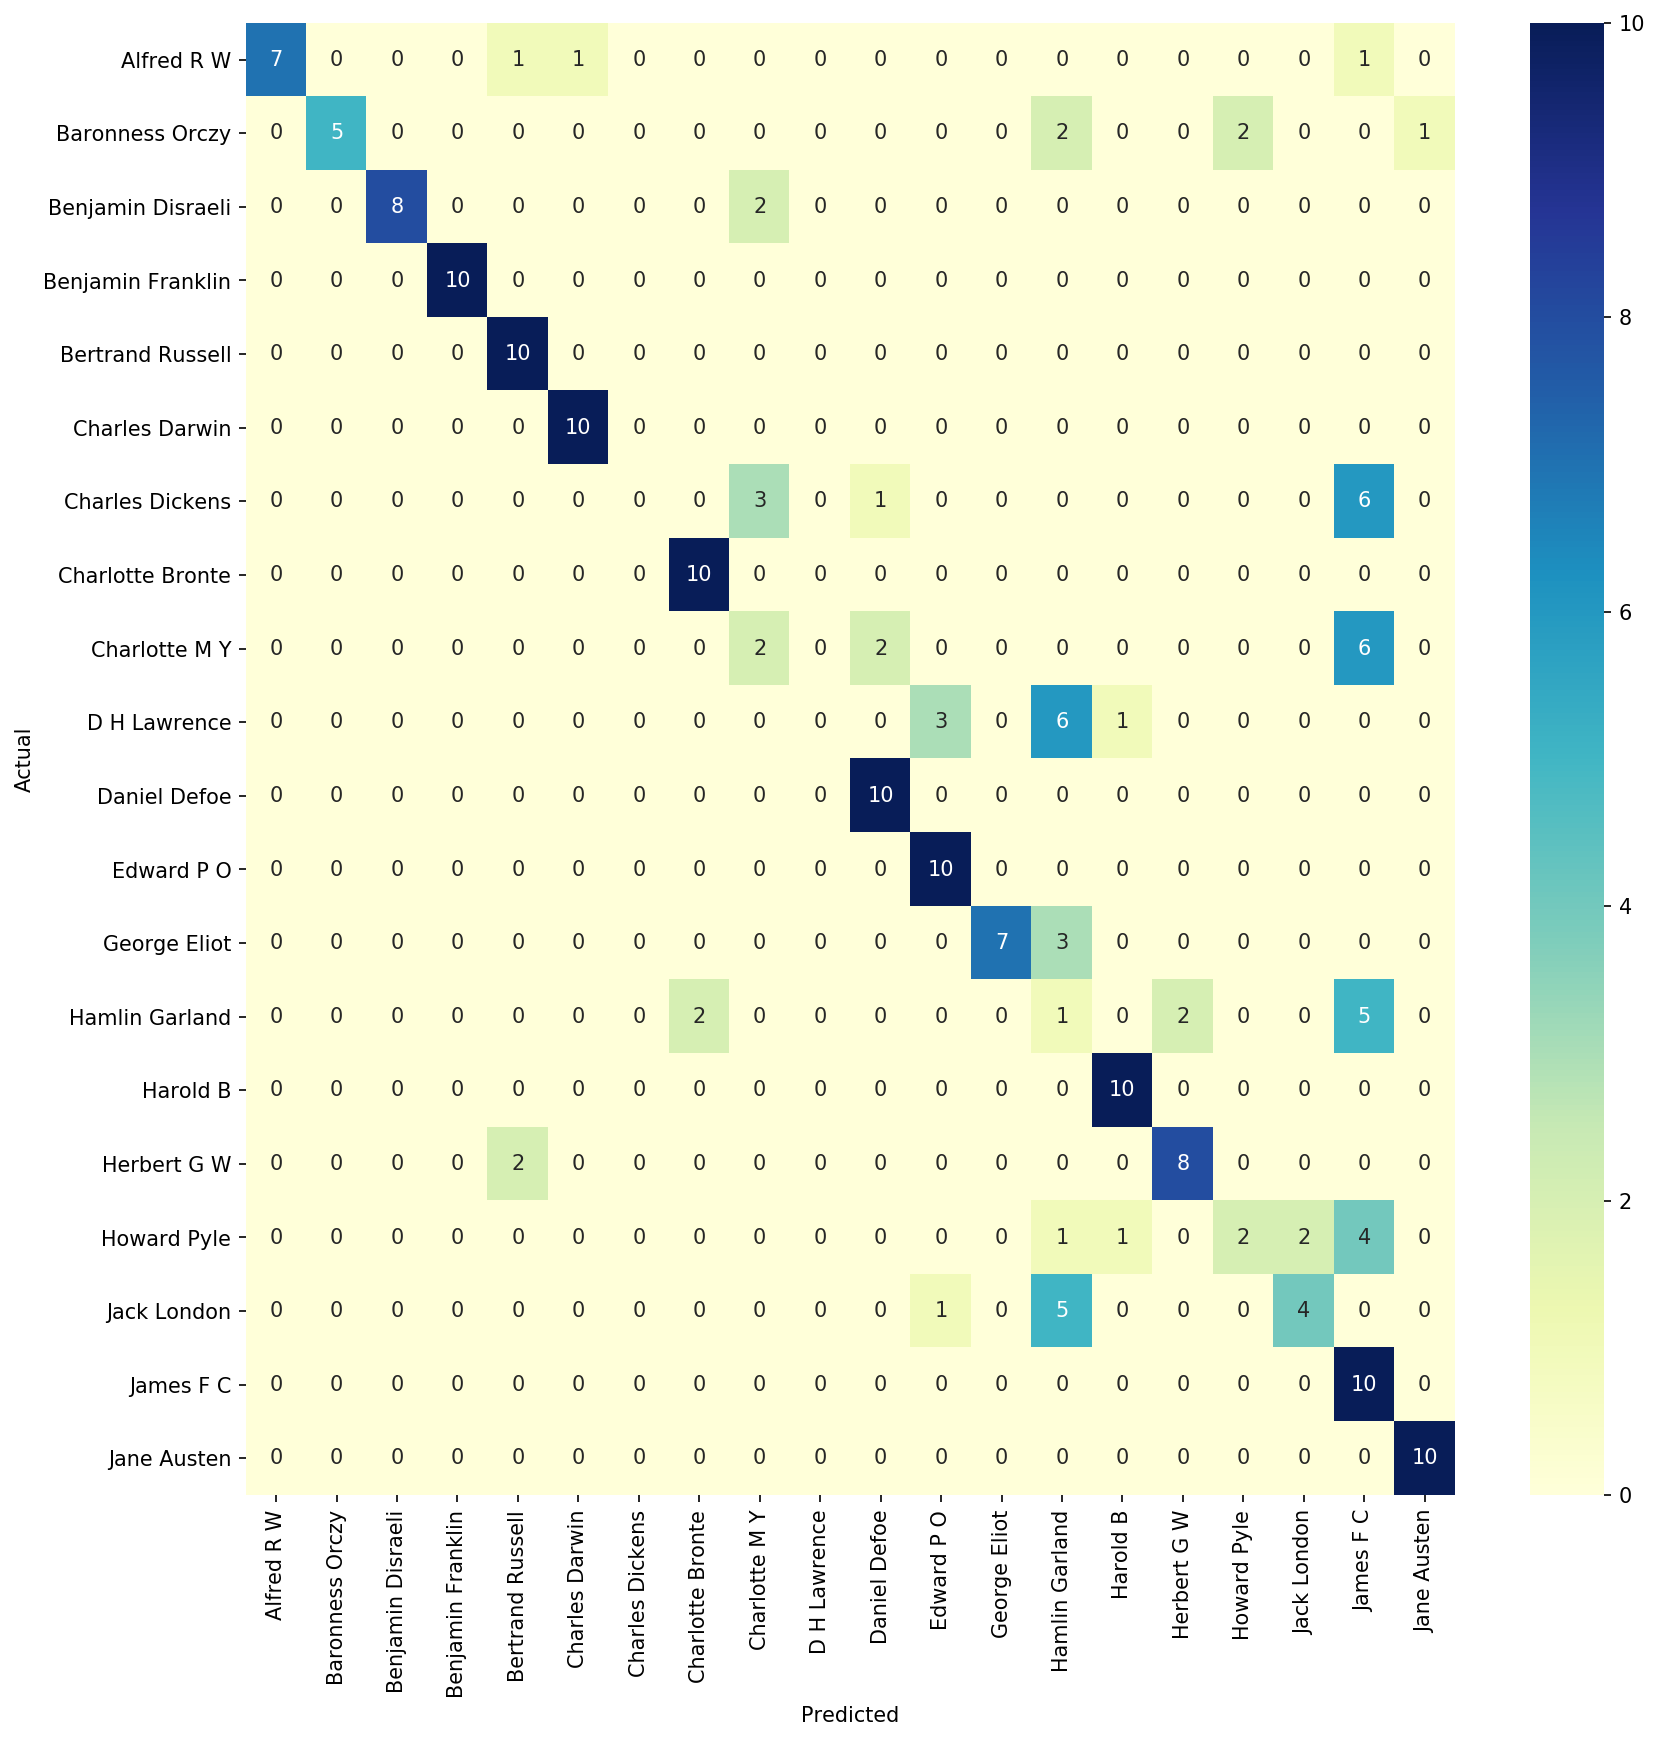

In [32]:
##1st order likelihood CM

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.figure(num=None, figsize=(13, 13), dpi=150, facecolor='w', edgecolor='k')

y_true = True_aut
y_pred = log_pred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

sn.heatmap(df_cm, cmap="YlGnBu", annot=True, xticklabels=Simp_True_Label, yticklabels=Simp_True_Label)# font size
#plt.savefig(r"C:/Users/Teng Li Yuan/Desktop/Dissertation result plot/1st order likelihood.png", dpi=199)

target_names = aut_orig
print(classification_report(y_true, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

    Alfred Russel Wallace       0.57      0.80      0.67        10
          Baronness Orczy       0.90      0.90      0.90        10
        Benjamin Disraeli       0.25      0.10      0.14        10
        Benjamin Franklin       1.00      0.70      0.82        10
         Bertrand Russell       1.00      0.70      0.82        10
           Charles Darwin       0.75      0.60      0.67        10
          Charles Dickens       0.17      0.10      0.12        10
         Charlotte Bronte       0.80      0.40      0.53        10
     Charlotte Mary Yonge       0.38      0.50      0.43        10
             D H Lawrence       0.00      0.00      0.00        10
             Daniel Defoe       0.67      0.80      0.73        10
Edward Phillips Oppenheim       0.80      0.80      0.80        10
             George Eliot       0.38      0.30      0.33        10
           Hamlin Garland       0.08      0.10      0.09     

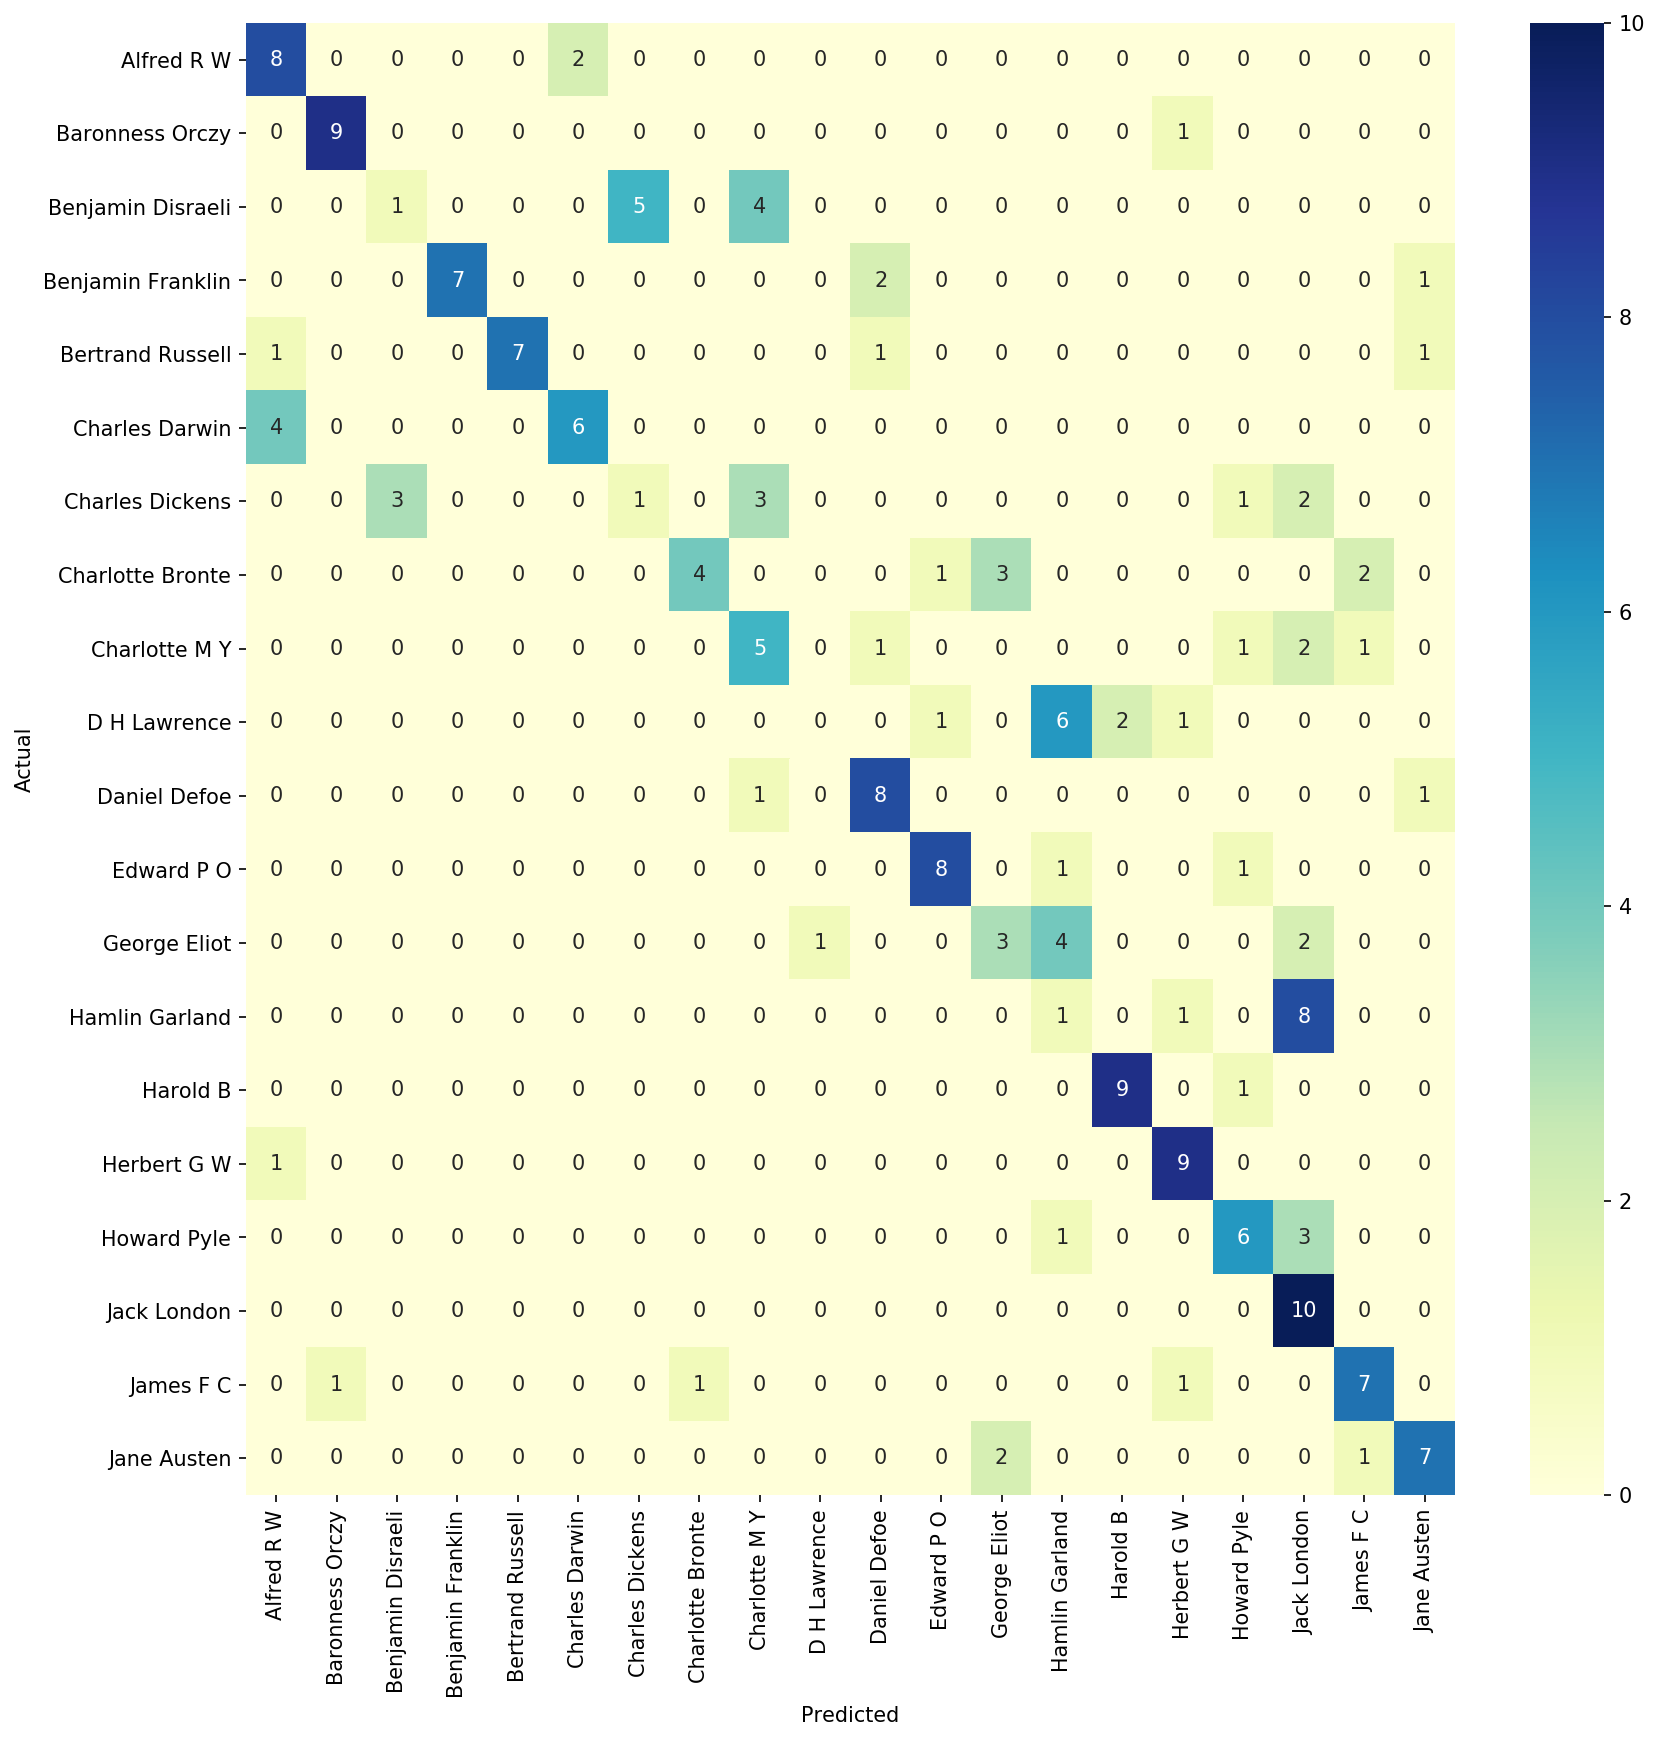

In [33]:
##1st order KL CM


y_true = True_aut
y_pred = KL_pred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


plt.figure(num=None, figsize=(13, 13), dpi=150, facecolor='w', edgecolor='k')
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, xticklabels=Simp_True_Label, yticklabels=Simp_True_Label)# font size
#plt.savefig(r"C:/Users/Teng Li Yuan/Desktop/Dissertation result plot/1st order KL.png")

target_names = aut_orig
print(classification_report(y_true, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

    Alfred Russel Wallace       0.56      0.90      0.69        10
          Baronness Orczy       1.00      0.70      0.82        10
        Benjamin Disraeli       0.88      0.70      0.78        10
        Benjamin Franklin       1.00      0.90      0.95        10
         Bertrand Russell       1.00      0.80      0.89        10
           Charles Darwin       0.80      0.40      0.53        10
          Charles Dickens       0.50      0.20      0.29        10
         Charlotte Bronte       0.80      0.40      0.53        10
     Charlotte Mary Yonge       0.33      0.10      0.15        10
             D H Lawrence       0.00      0.00      0.00        10
             Daniel Defoe       0.88      0.70      0.78        10
Edward Phillips Oppenheim       0.71      1.00      0.83        10
             George Eliot       1.00      0.20      0.33        10
           Hamlin Garland       0.00      0.00      0.00     

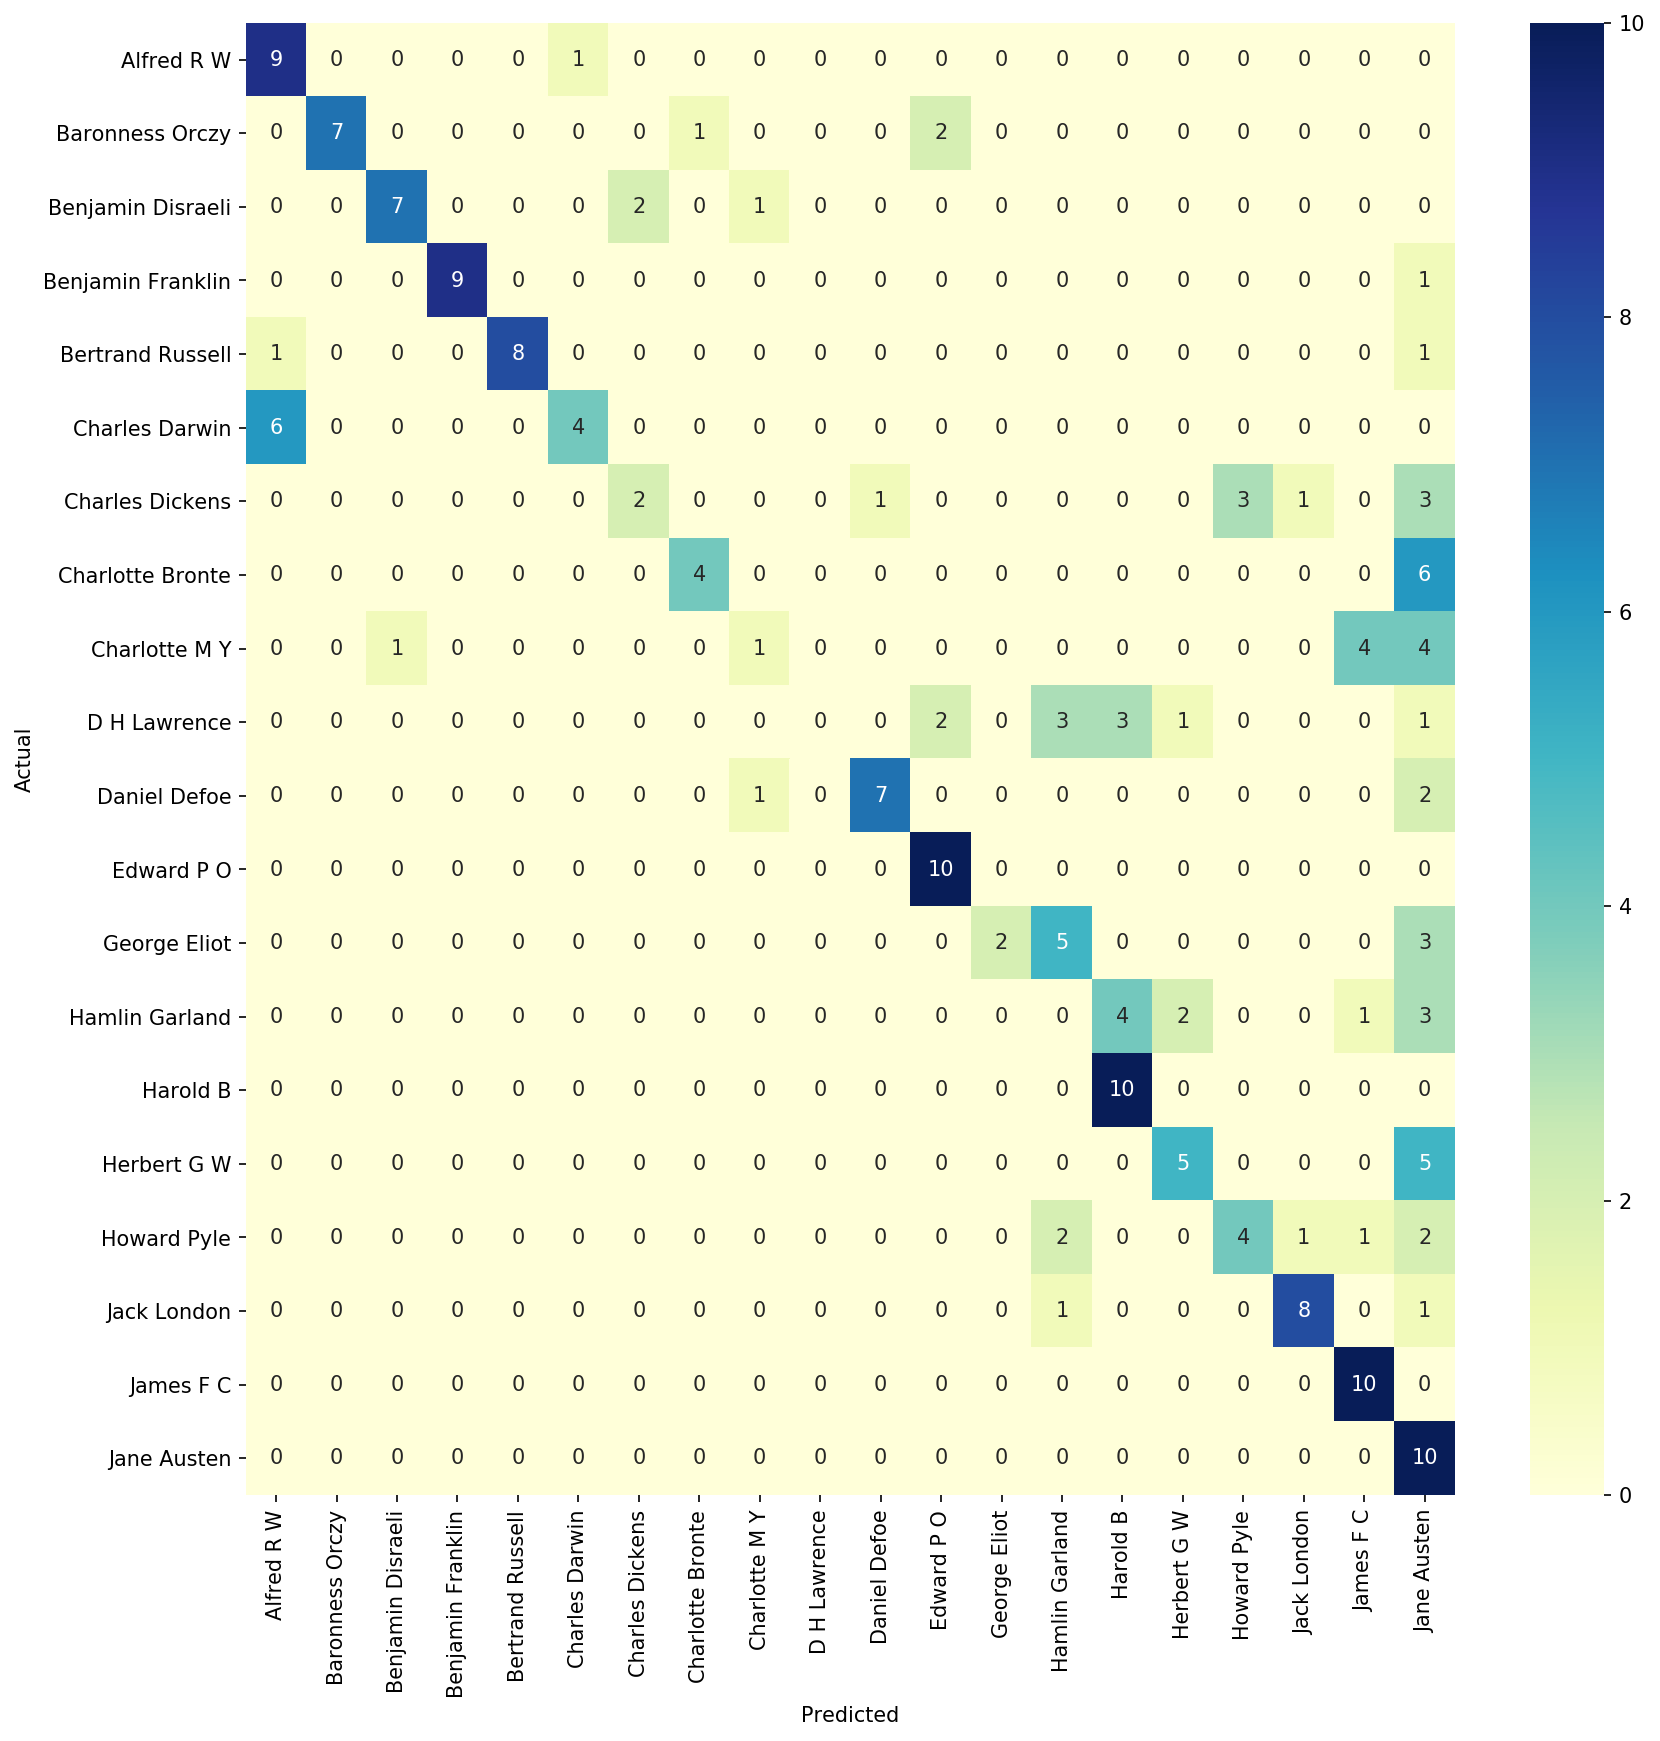

In [34]:
##1st order JS CM


y_true = True_aut
y_pred = JS_pred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(num=None, figsize=(13, 13), dpi=150, facecolor='w', edgecolor='k')
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, xticklabels=Simp_True_Label, yticklabels=Simp_True_Label)# font size

#plt.savefig(r"C:/Users/Teng Li Yuan/Desktop/Dissertation result plot/1st order JS.png")

target_names = aut_orig
print(classification_report(y_true, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

    Alfred Russel Wallace       0.75      0.90      0.82        10
          Baronness Orczy       1.00      1.00      1.00        10
        Benjamin Disraeli       1.00      0.60      0.75        10
        Benjamin Franklin       1.00      1.00      1.00        10
         Bertrand Russell       0.91      1.00      0.95        10
           Charles Darwin       0.88      0.70      0.78        10
          Charles Dickens       0.33      0.10      0.15        10
         Charlotte Bronte       0.83      1.00      0.91        10
     Charlotte Mary Yonge       0.42      0.50      0.45        10
             D H Lawrence       0.00      0.00      0.00        10
             Daniel Defoe       0.83      1.00      0.91        10
Edward Phillips Oppenheim       0.91      1.00      0.95        10
             George Eliot       1.00      0.70      0.82        10
           Hamlin Garland       0.09      0.10      0.10     

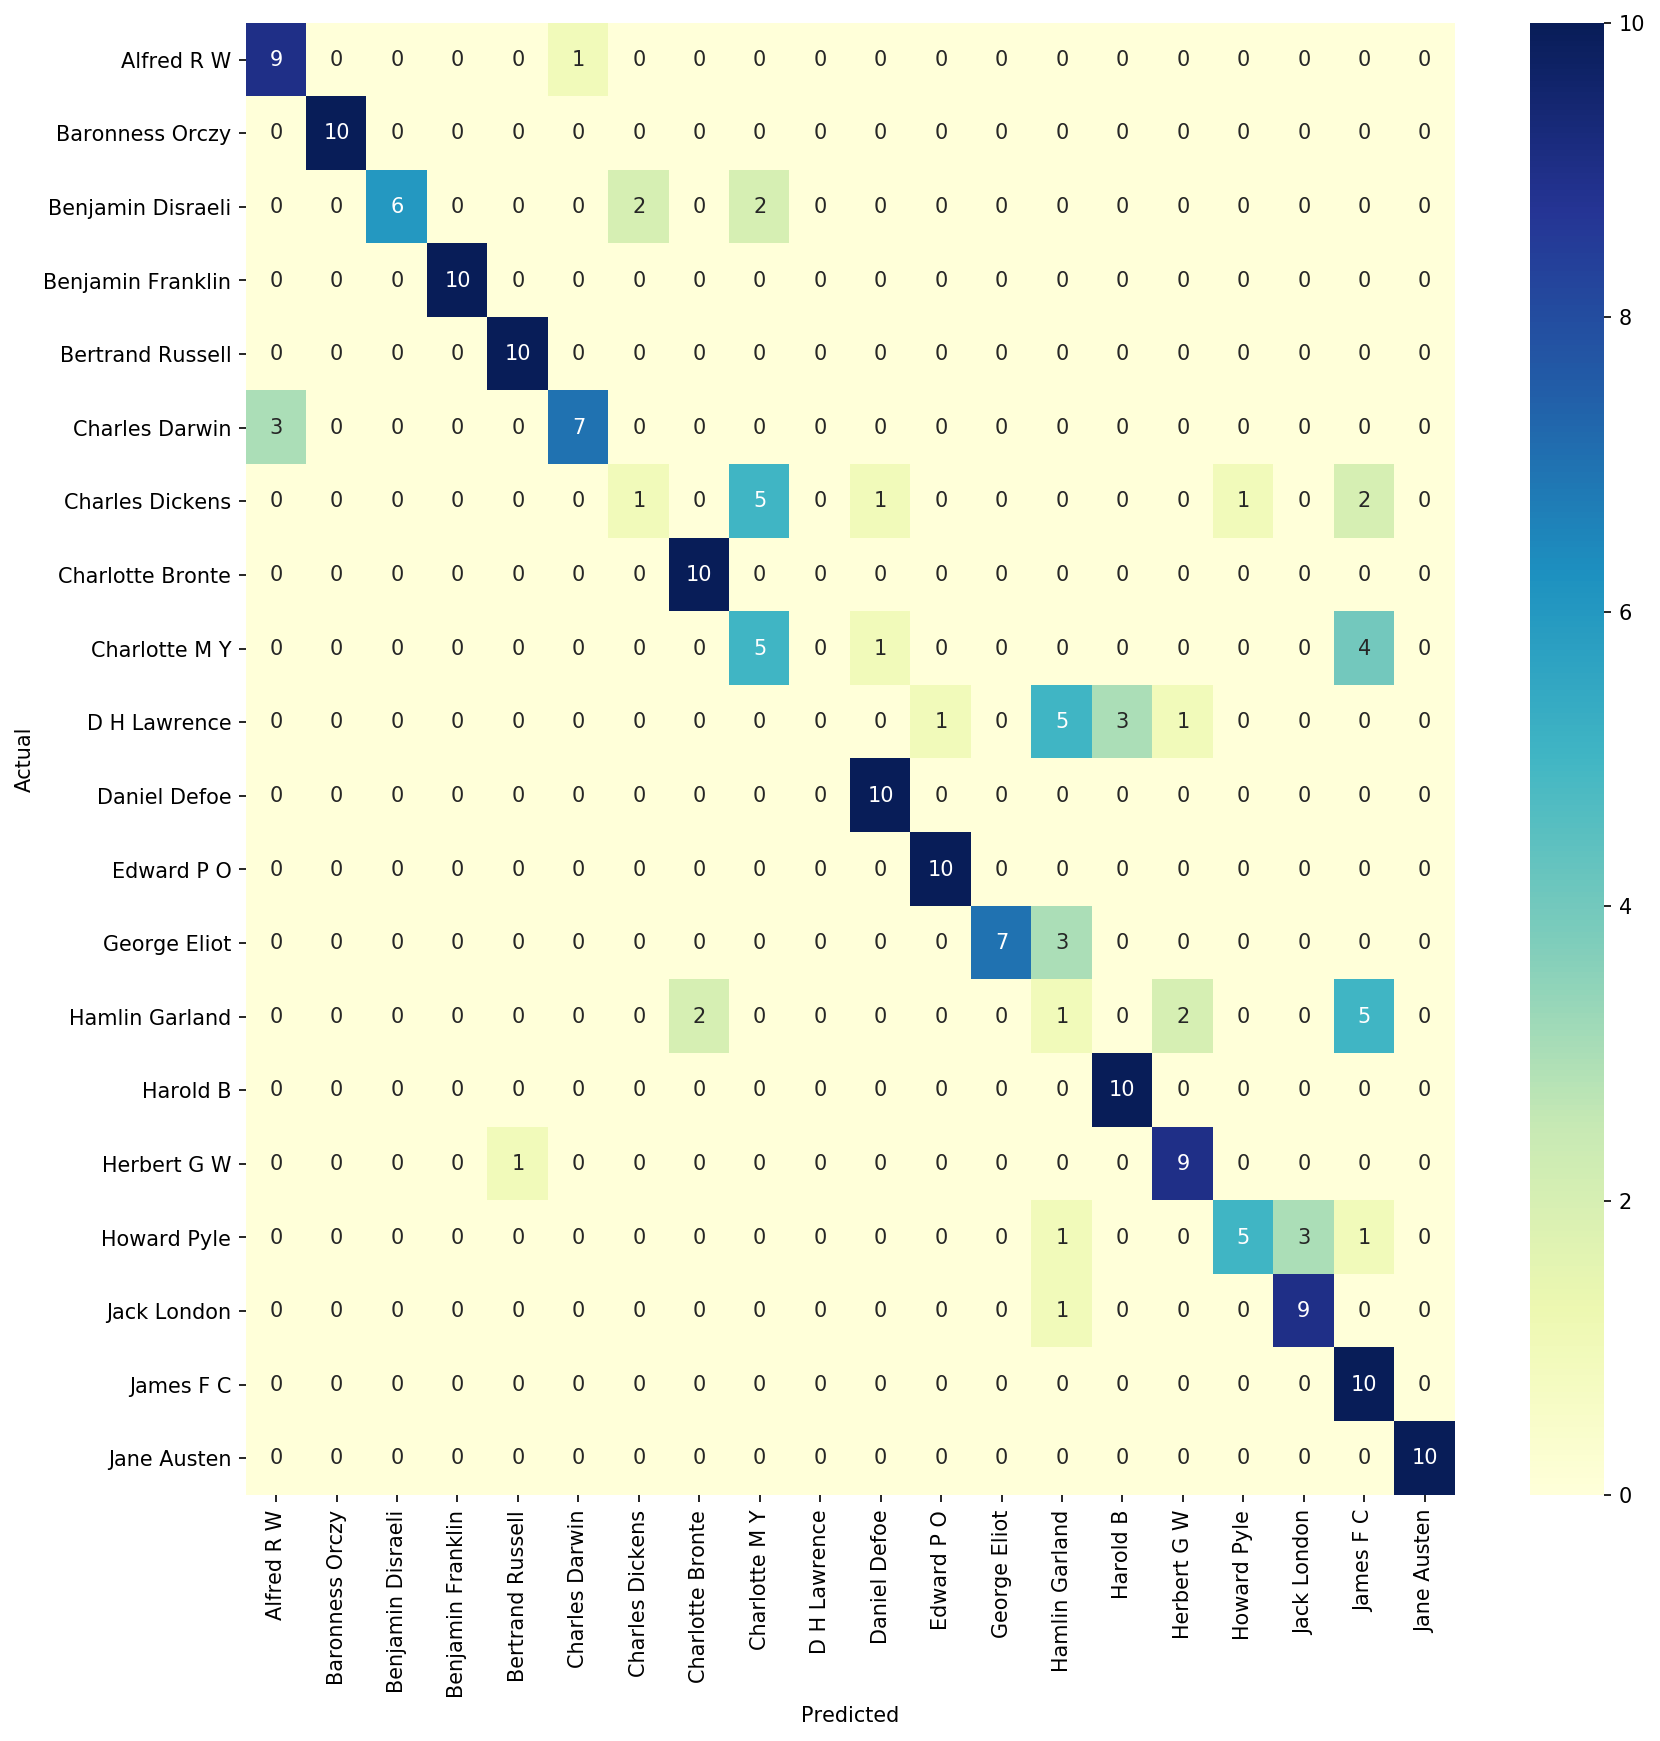

In [35]:
##1st order Ensemble CM


y_true = True_aut
y_pred = ensemb_pred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(num=None, figsize=(13, 13), dpi=150, facecolor='w', edgecolor='k')
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, xticklabels=Simp_True_Label, yticklabels=Simp_True_Label)# font size

#plt.savefig(r"C:/Users/Teng Li Yuan/Desktop/Dissertation result plot/1st order ensemble.png")

target_names = aut_orig
print(classification_report(y_true, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

    Alfred Russel Wallace       0.67      1.00      0.80        10
          Baronness Orczy       0.56      0.90      0.69        10
        Benjamin Disraeli       0.80      0.40      0.53        10
        Benjamin Franklin       0.91      1.00      0.95        10
         Bertrand Russell       0.90      0.90      0.90        10
           Charles Darwin       1.00      0.20      0.33        10
          Charles Dickens       0.14      0.20      0.17        10
         Charlotte Bronte       0.60      0.90      0.72        10
     Charlotte Mary Yonge       0.36      0.50      0.42        10
             D H Lawrence       0.58      0.70      0.64        10
             Daniel Defoe       0.83      1.00      0.91        10
Edward Phillips Oppenheim       0.82      0.90      0.86        10
             George Eliot       1.00      0.20      0.33        10
           Hamlin Garland       0.60      0.60      0.60     

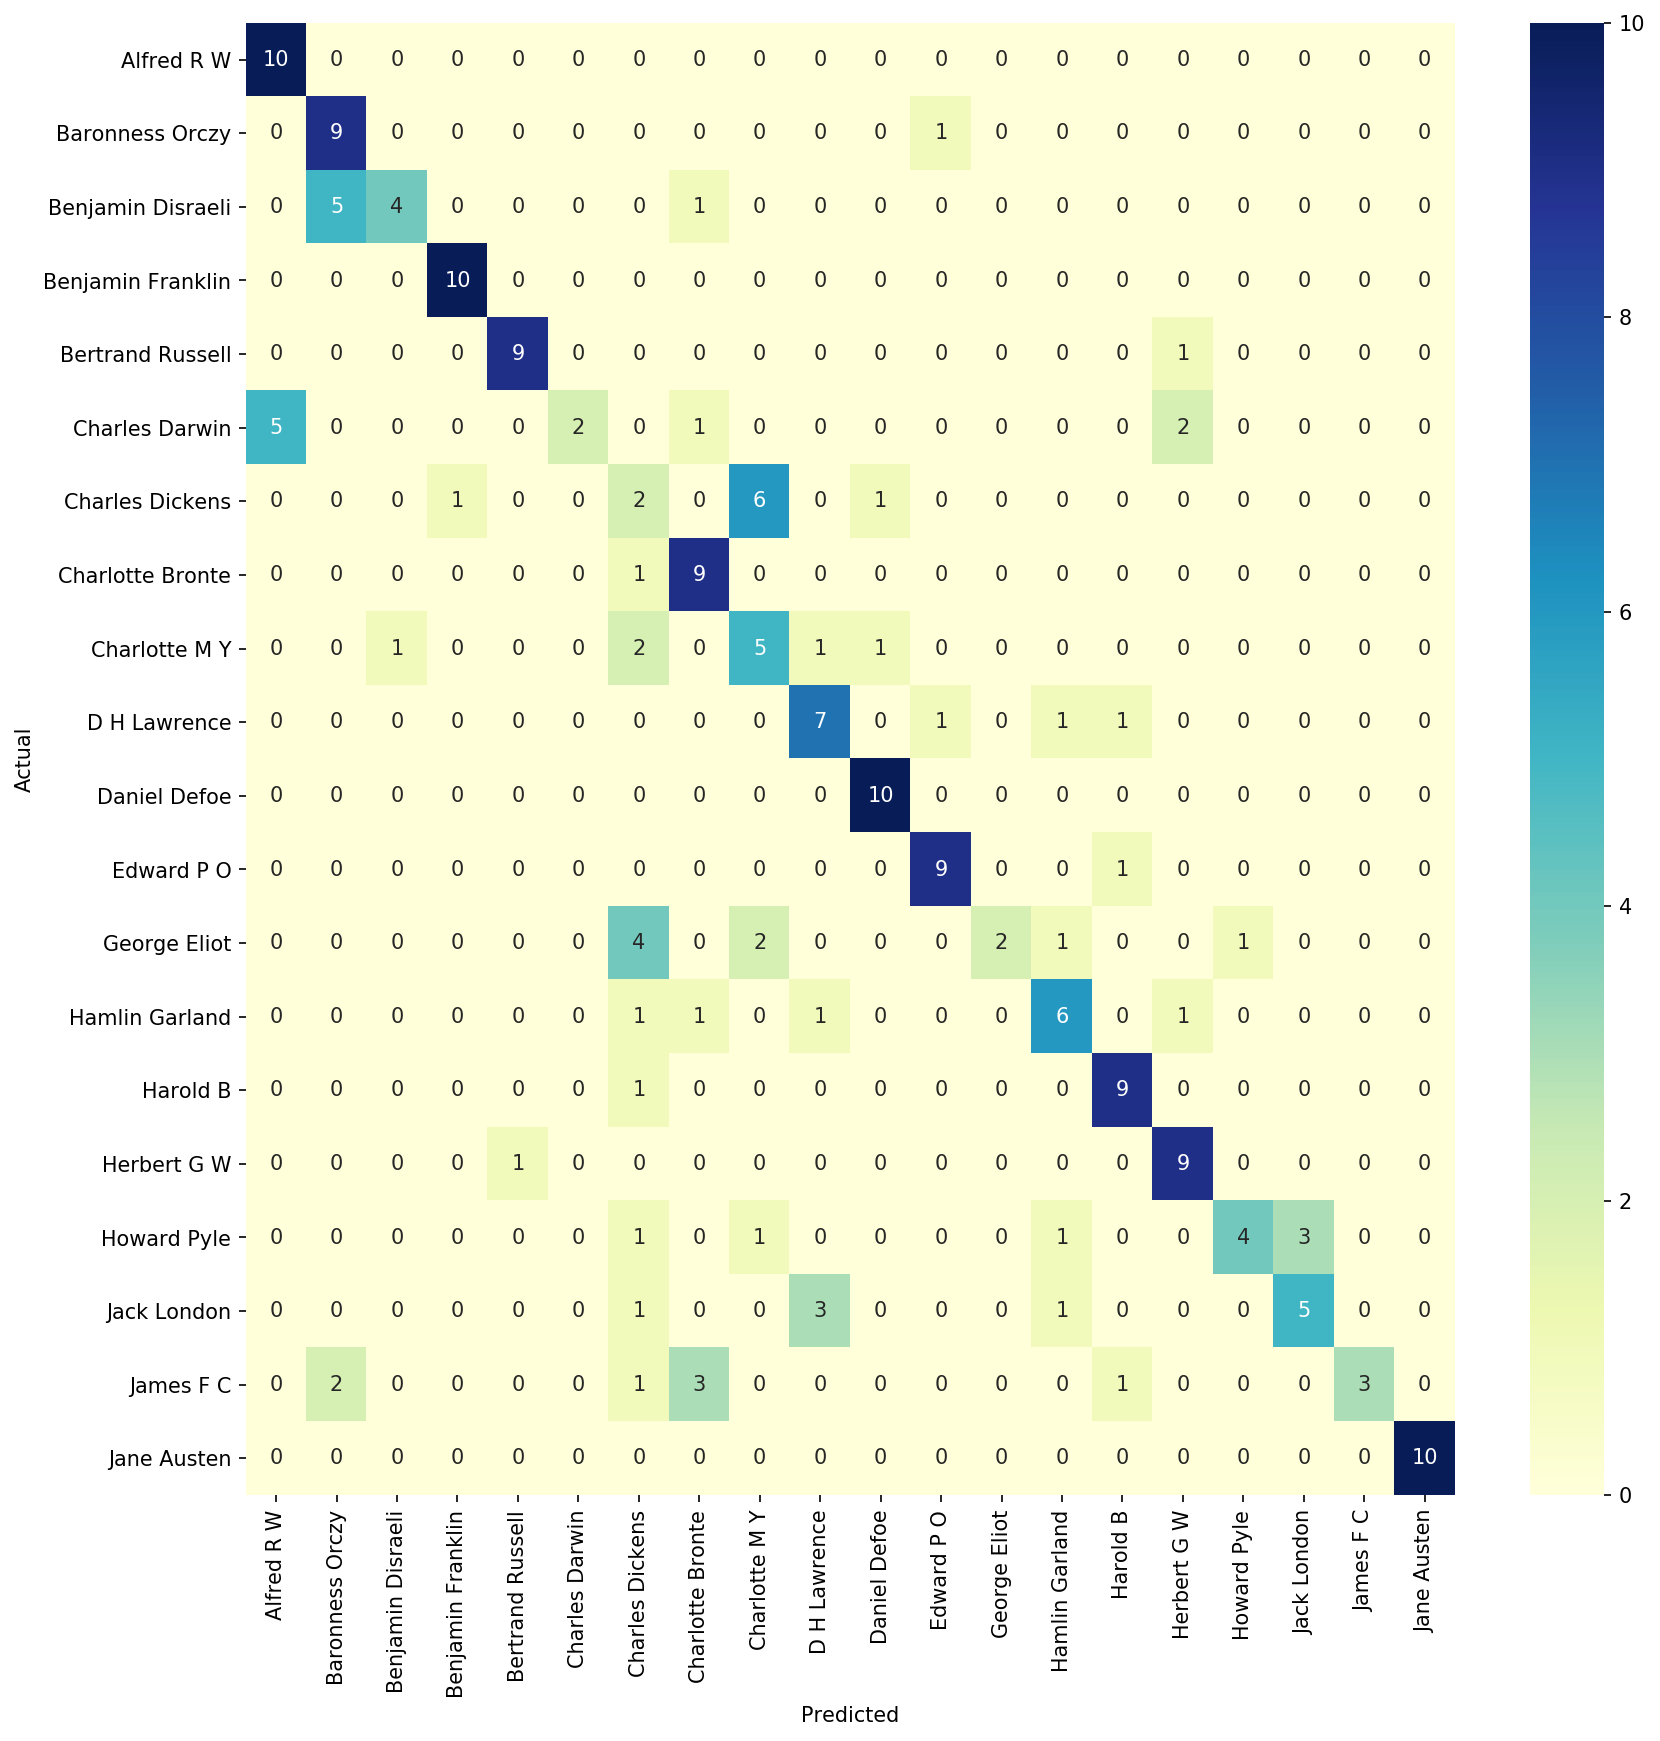

In [36]:
##1st order LDA CM


y_true = True_aut
y_pred = LDA_pred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(num=None, figsize=(13, 13), dpi=150, facecolor='w', edgecolor='k')
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, xticklabels=Simp_True_Label, yticklabels=Simp_True_Label)# font size

#plt.savefig(r"C:/Users/Teng Li Yuan/Desktop/Dissertation result plot/1st order LDA.png")

target_names = aut_orig
print(classification_report(y_true, y_pred, target_names=target_names))

In [40]:
# ## Uncomment this part to find the optimum number to assign on q(x) = 0 case
# KL_para =[]
# KL_para_acc = []
# for thres in np.arange(0.1, 0.5, 0.02):

#     KL_prediction_list = []
#     #1 chapter to 8 book
#     for j in range (len(test_chapter_list_path)):
#         KL_divergence_chap_trans_and_book_trans_list = []
#         for i in range (len(book_path)):
#             single_test_to_1_book = kl_divergence(test_chapter_trans_list[j], trans_list[i], thres)
#             sum_of_1_test_to_1_book = np.sum(single_test_to_1_book) #Sum of all KL divergence
#             KL_divergence_chap_trans_and_book_trans_list.append(sum_of_1_test_to_1_book)

#         book_prediction = book_path[KL_divergence_chap_trans_and_book_trans_list.index(min(KL_divergence_chap_trans_and_book_trans_list))]
#         KL_prediction_list.append(book_prediction)        
    
#     dudu = accuracy(KL_prediction_list, test_chapter_list_path)
#     print(thres, "------", dudu)
#     KL_para.append(thres)
#     KL_para_acc.append(dudu)

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)
lda.explained_variance_ratio_

array([0.20179661, 0.17212378, 0.10682708, 0.07083887, 0.05866293,
       0.04860195, 0.04477211, 0.04200303, 0.03845109, 0.03470807,
       0.02836148, 0.02652931, 0.02515255, 0.02139394, 0.01946871,
       0.01890061, 0.01679509, 0.01279867, 0.0118141 ])

In [42]:
temp_sim = ['Alfred R W',
 'Baronness Orczy',
 'Benjamin Disraeli',
 'Benjamin Franklin',
 'Bertrand Russell',
 'Charles Darwin',
 'Charles Dickens',
 'Charlotte Bronte',
 'Charlotte M Y',
 'D H Lawrence',
 'Daniel Defoe',
 'Edward P O',
 'George Eliot',
 'Hamlin Garland',
 'Harold B',
 'Herbert G W',
 'Howard Pyle',
 'Jack London',
 'James F C',
 'Jane Austen']

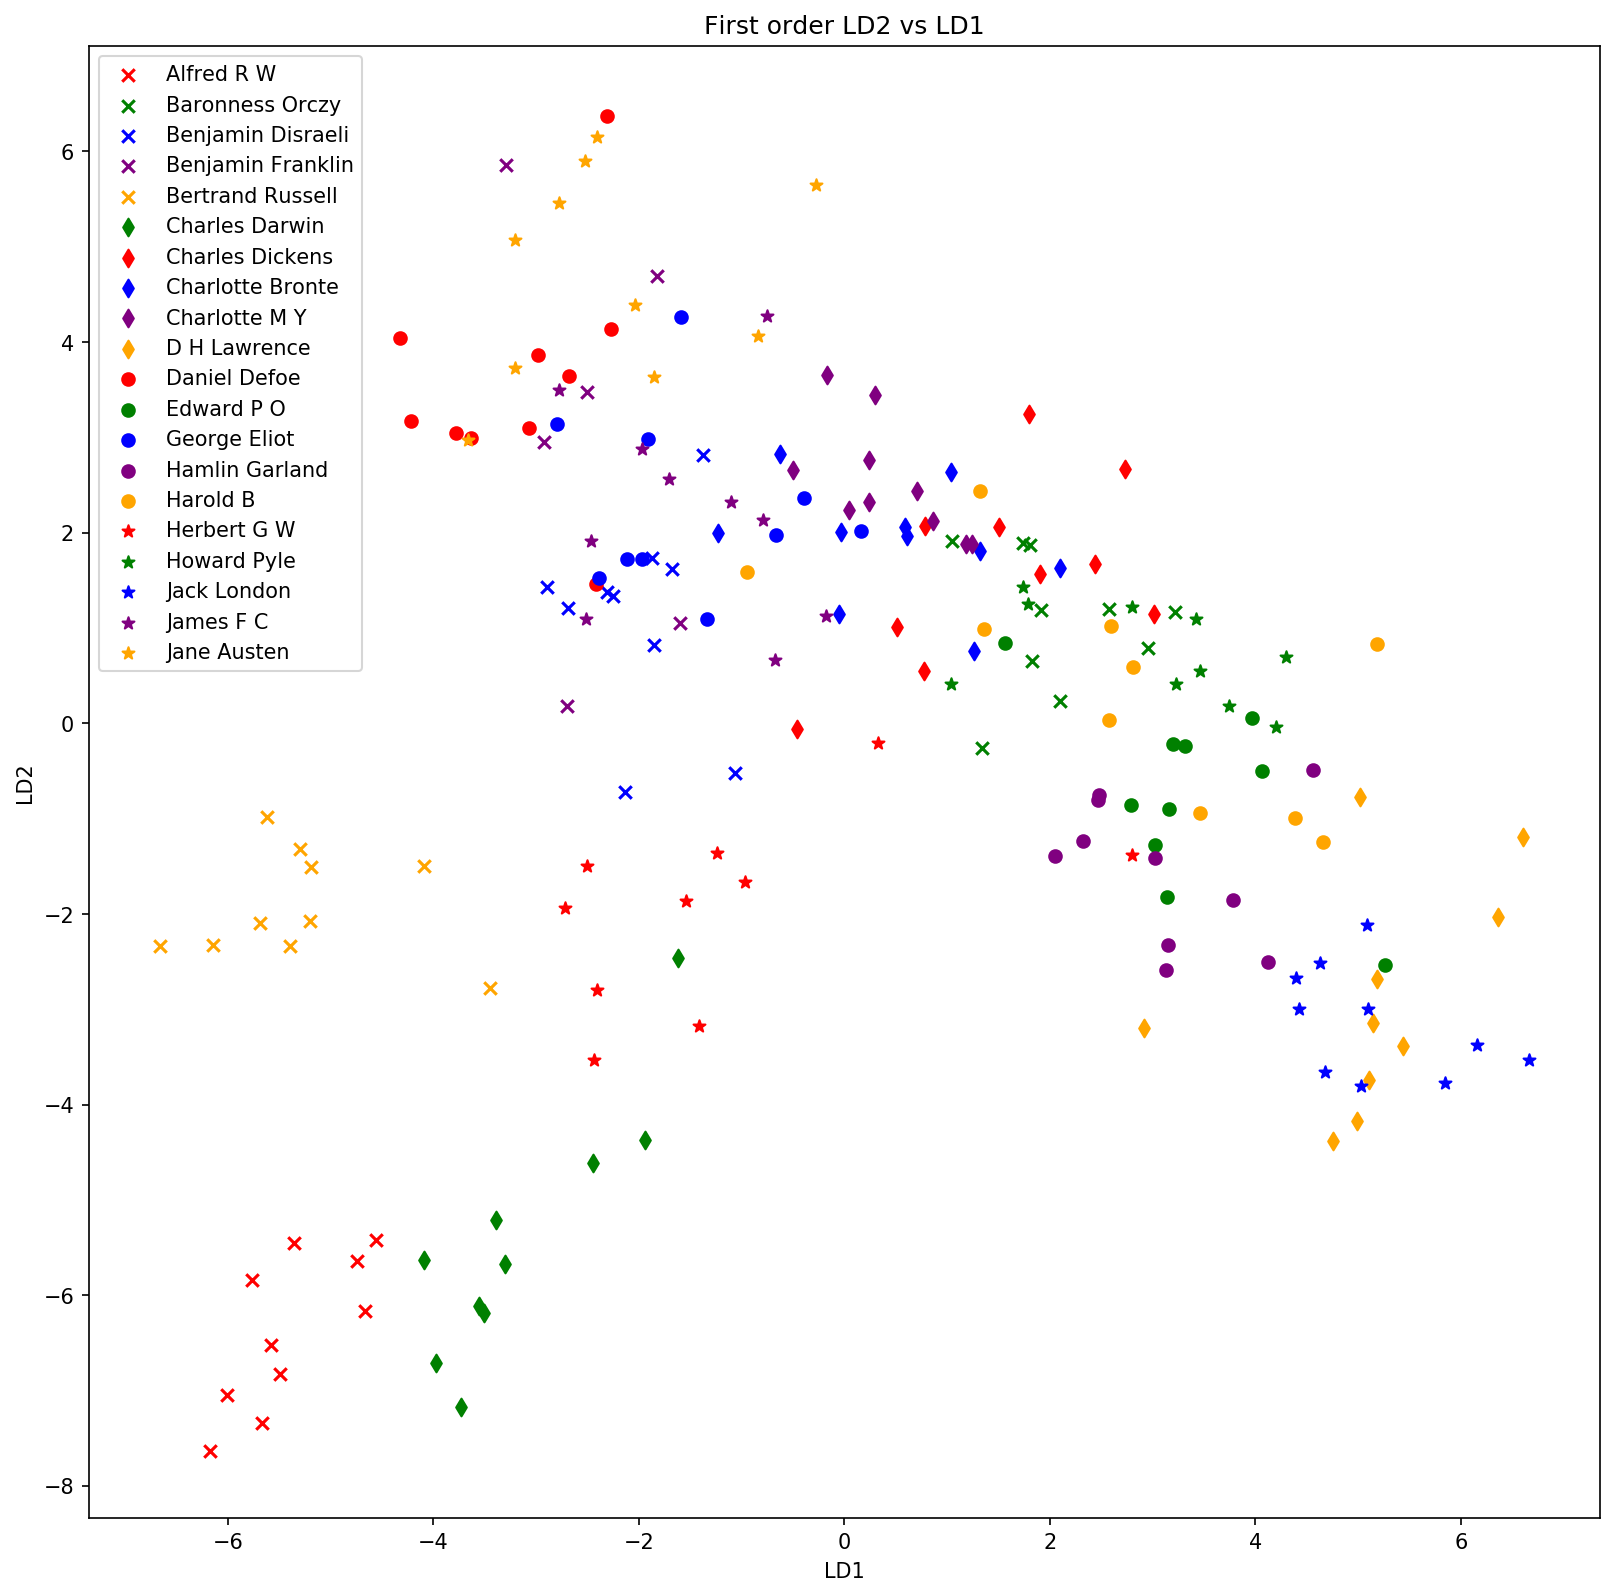

In [43]:
import matplotlib.pyplot as plt

# LDA_1 = X_lda[:,0],
# LDA_2 = X_lda[:,1],
plt.figure(num=None, figsize=(13, 13), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(X_lda[0:10,0], X_lda[0:10,1], marker = "x", c='red', label=temp_sim[0])
plt.scatter(X_lda[10:20,0], X_lda[10:20,1], marker = "x", c='green', label=temp_sim[1])
plt.scatter(X_lda[20:30,0], X_lda[20:30,1], marker = "x", c='blue', label=temp_sim[2])
plt.scatter(X_lda[30:36,0], X_lda[30:36,1], marker = "x", c='purple', label=temp_sim[3])
plt.scatter(X_lda[36:46,0], X_lda[36:46,1], marker = "x", c='orange', label=temp_sim[4])
plt.scatter(X_lda[46:56,0], X_lda[46:56,1], marker = "d", c='green', label=temp_sim[5])
plt.scatter(X_lda[56:66,0], X_lda[56:66,1], marker = "d", c='red', label=temp_sim[6])
plt.scatter(X_lda[66:76,0], X_lda[66:76,1], marker = "d", c='blue', label=temp_sim[7])
plt.scatter(X_lda[76:86,0], X_lda[76:86,1], marker = "d", c='purple', label=temp_sim[8])
plt.scatter(X_lda[86:96,0], X_lda[86:96,1], marker = "d", c='orange', label=temp_sim[9])
plt.scatter(X_lda[96:106,0], X_lda[96:106,1], marker = "o", c='red', label=temp_sim[10])
plt.scatter(X_lda[106:116,0], X_lda[106:116,1], marker = "o", c='green', label=temp_sim[11])
plt.scatter(X_lda[116:126,0], X_lda[116:126,1], marker = "o", c='blue', label=temp_sim[12])
plt.scatter(X_lda[126:136,0], X_lda[126:136,1], marker = "o", c='purple', label=temp_sim[13])
plt.scatter(X_lda[136:146,0], X_lda[136:146,1], marker = "o", c='orange', label=temp_sim[14])
plt.scatter(X_lda[146:156,0], X_lda[146:156,1], marker = "*", c='red', label=temp_sim[15])
plt.scatter(X_lda[156:166,0], X_lda[156:166,1], marker = "*", c='green', label=temp_sim[16])
plt.scatter(X_lda[166:176,0], X_lda[166:176,1], marker = "*", c='blue', label=temp_sim[17])
plt.scatter(X_lda[176:186,0], X_lda[176:186,1], marker = "*", c='purple', label=temp_sim[18])
plt.scatter(X_lda[186:196, 0], X_lda[186:196, 1], marker = "*", c='orange', label=temp_sim[19])

#plt.scatter(x, y, c='lightblue', label='Class 2')

plt.legend()

plt.title('First order LD2 vs LD1')
plt.xlabel('LD1')
plt.ylabel('LD2')

#plt.savefig(r"C:/Users/Teng Li Yuan/Desktop/Dissertation result plot/LDA1 LD2.png")
plt.show()

In [ ]:
# %store -r log_pred_2
# %store -r KL_pred_2
# %store -r LDA_pred_2
# %store -r log_pred_3
# %store -r KL_pred_3